In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.manifold import TSNE
from tqdm import tqdm
import seaborn as sns
import pandas as pd

2025-11-22 17:47:45.563621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define the IterTensorFlowToPyTorchDataset class (same as in original code)
class IterTensorFlowToPyTorchDataset(torch.utils.data.IterableDataset):
    def __init__(self, tf_dataset_path):
        """
        A PyTorch dataset that fetches data from a TensorFlow dataset.
        
        Args:
        - tf_dataset_path: Path to the TensorFlow dataset.
        """
        self.tf_path = tf_dataset_path
        self.tf_dataset = tf.data.Dataset.load(tf_dataset_path)
        
    def __len__(self):
        return tf.data.experimental.cardinality(self.tf_dataset).numpy()
            
    def __iter__(self):
        for element in self.tf_dataset.as_numpy_iterator():
            features, labels = element
            features = torch.tensor(features, dtype=torch.float32).view(1, -1)  # Reshape to match model input shape
            labels = torch.tensor(labels, dtype=torch.float32)
            yield features, labels
    
    def size(self, in_gb=False):
        ''' Returns the size of the Dataset in MB or GB. '''
        if os.path.exists(self.tf_path):
            if os.path.isfile(self.tf_path):
                size_in_bytes = os.path.getsize(self.tf_path)
            elif os.path.isdir(self.tf_path):
                size_in_bytes = sum(
                    os.path.getsize(os.path.join(root, file))
                    for root, _, files in os.walk(self.tf_path)
                    for file in files
                )
            else:
                raise ValueError(f"Path '{self.tf_path}' is neither a file nor a directory.")
            
            if not in_gb:
                size_in_mb = size_in_bytes / (1024*1024)  # Convert to MB
                return size_in_mb
            else:
                size_in_gb = size_in_bytes / (1024*1024*1024)  # Convert to GB
                return size_in_gb
        else:
            raise FileNotFoundError(f"Data file not found at {self.tf_path}")

# Define a modified version of the model that extracts latent representations
class LatentSpaceExtractor(nn.Module):
    def __init__(self, model, layer_name):
        super(LatentSpaceExtractor, self).__init__()
        self.model = model
        self.layer_name = layer_name
        self.activation = {}
        
        # Register hooks to extract activations
        self._register_hooks()
        
    def _register_hooks(self):
        def get_activation(name):
            def hook(model, input, output):
                self.activation[name] = output.detach()
            return hook
        
        # Register hook for the specified layer
        if self.layer_name == 'fc1': 
           self.model.fc1.register_forward_hook(get_activation('fc1'))
        if self.layer_name == 'fc2':
            self.model.fc2.register_forward_hook(get_activation('fc2'))
        elif self.layer_name == 'transformer':
            self.model.transformer.register_forward_hook(get_activation('transformer'))
    
    def forward(self, x):
        # Forward pass through the model
        _ = self.model(x)
        # Return the activation of the specified layer
        return self.activation[self.layer_name]


In [3]:
# Deep model
class DeepModel(nn.Module):
    """
    Deep CNN model for regression.
    
    The model requires initialization before loading weights. 
    To initialize the model, call model.initialize(input_tensor).
    """
    def __init__(self, num_vars):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1, dilation=1)
        # self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, dilation=2)
        # self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=1, dilation=2)
        # self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=32, stride=1, dilation=2)
        # self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.flatten = nn.Flatten()
        self.fc1 = None # This layer will be initialized in the forward method
        # self.drp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        # self.drp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_vars)
    
    def forward(self, x):  
        x = self.conv1(x)
        # x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        # x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        # x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        # Initialize the first fully connected layer the first time forward is run
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)
            
        x = self.fc1(x)
        x = torch.relu(x)
        # x = self.drp1(x)
        
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.drp2(x)
        
        x = self.fc3(x)
        return x

    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")

class HybridDeepModel(nn.Module):
    def __init__(self, num_variables):
        super(HybridDeepModel, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1, dilation=1)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, dilation=2)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=1, dilation=2)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=32, stride=1, dilation=2)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)

        # Normalization before Transformer
        self.norm = nn.LayerNorm(512)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 128)  # Adjust input size based on the output of the last conv layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_variables)
    
    def forward(self, x):
        # CNN Feature Extraction
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)   
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool4(x) 
        
        # Prepare for Transformer
        # Transpose to match Encoder input shape: (batch_size, sequence_length, embed_dim)
        x = x.permute(0, 2, 1)

        x = self.norm(x)

        x = self.transformer(x)  # Output: (sequence_length, batch_size, embed_dim)
        x = x[:, -1, :]  # Take the last sequence element (batch_size, embed_dim)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)

        return x
    
    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("Model initialized successfully.")


In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set path to your dataset - update this to match your environment
path = '/home/sakellariou/hero_disk/test/'  # <------- Change path here

# Load dataset
print('Loading dataset...')
test_dataset = IterTensorFlowToPyTorchDataset(path + 'test_dataset')
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load model - update with your model class and path
print('Loading model...')
model_class = HybridDeepModel  # Update this to match your model class
print(f'Using model: {model_class.__name__}')
model_path = f'./{model_class.__name__}_results/{model_class.__name__}_best_model.pth'  # Update this path <-------

# Recreate model architecture
num_vars = 6
model = model_class(num_vars).to(device)

exact_from_scratch = True  # Set to True if you want to exact latent representations from scratch
                            # If False, it will load from saved latent data if available 
if exact_from_scratch:
    # Load weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print('Model weights loaded successfully.')
    except Exception as e:
        print(f'Error loading model weights: {e}')
    # Initialize model if needed (for dynamic FC layers)
    with torch.no_grad():
        inputs, _ = next(iter(test_loader))
        inputs = inputs.to(device)
        model.forward(inputs)  # Initialize dynamic layers
    # Try loading again
    model.load_state_dict(torch.load(model_path, map_location=device))
    print('Model weights loaded successfully after initialization.')

    # Create latent space extractor - choose which layer to extract from
    # Options could be 'fc1' (before final layer), 'fc2', or 'transformer' (after transformer)
    latent_extractor = LatentSpaceExtractor(model, layer_name='fc1')  # <------- Change layer name here
    latent_extractor.to(device)
    latent_extractor.eval()
    
    # Extract latent representations from test set
    print('Extracting latent representations...')
    latent_vectors = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            
            # Extract latent representation
            latent = latent_extractor(inputs)
            
            # If we're getting output from transformer, we need to reshape
            if latent_extractor.layer_name == 'transformer':
                # Take the last time step from transformer output
                latent = latent[-1, :, :]
                
            # Move to CPU and convert to numpy
            latent_vectors.append(latent.cpu().numpy())
            labels_list.append(labels.numpy())
    
    # Concatenate all batches
    latent_vectors = np.vstack(latent_vectors)
    labels_list = np.vstack(labels_list)
    
    print(f'Extracted {latent_vectors.shape[0]} latent vectors of dimension {latent_vectors.shape[1]}')
    
    print('Saving latent representations to file...')
    destination_folder = f'./tsne_plots'  # <---- Change this to your desired destination folder
    if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
            
    np.savez(f'{destination_folder}/{model.__class__.__name__}_latent_data.npz', latent=latent_vectors, labels=labels_list)

else:
    print('Loading latent representations from file...')
    destination_folder = f'./tsne_plots'  # <---- Change this to your desired destination folder
    data = np.load(f'{destination_folder}/{model.__class__.__name__}_latent_data.npz')
    latent_vectors = data['latent']
    labels_list = data['labels']
    print(f'Loaded {latent_vectors.shape[0]} latent vectors of dimension {latent_vectors.shape[1]}')


# Apply t-SNE
print('Applying t-SNE...')
# You can limit the number of samples to speed up t-SNE
max_samples = 5000
if latent_vectors.shape[0] > max_samples:
    indices = np.random.choice(latent_vectors.shape[0], max_samples, replace=False)
    latent_subset = latent_vectors[indices]
    labels_subset = labels_list[indices]
else:
    latent_subset = latent_vectors
    labels_subset = labels_list

# Apply t-SNE with perplexity tuning
tsne = TSNE(n_components=2, perplexity=40, max_iter=1000, random_state=42, verbose=1)
latent_tsne = tsne.fit_transform(latent_subset)

# Create dataframe for plotting with parameters as columns
param_names = ['Mass 1', 'Mass 2', 'Distance', 'Inclination', 'Spin 1', 'Spin 2']
df = pd.DataFrame(data=labels_subset, columns=param_names)
df['x'] = latent_tsne[:, 0]
df['y'] = latent_tsne[:, 1]

Using device: cuda
Loading dataset...
Loading model...
Using model: HybridDeepModel
Model weights loaded successfully.
Model weights loaded successfully after initialization.
Extracting latent representations...


100%|██████████| 13641/13641 [31:58<00:00,  7.11it/s]


Extracted 1746000 latent vectors of dimension 128
Saving latent representations to file...
Applying t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 1.003s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 35.287401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.873592
[t-SNE] KL divergence after 1000 iterations: 0.633512


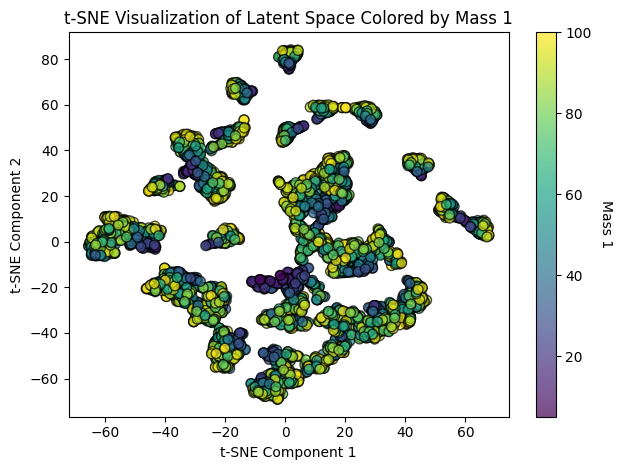

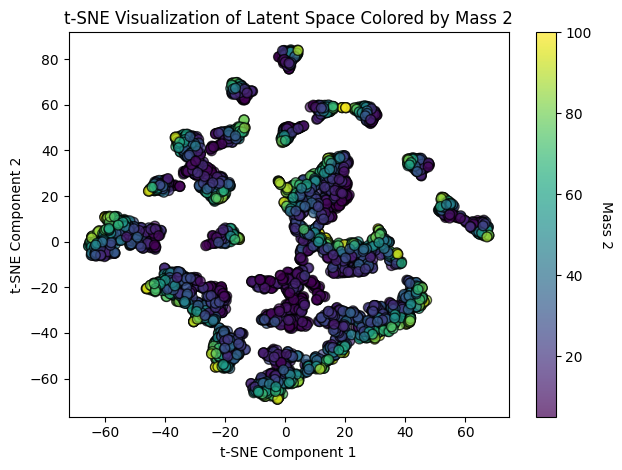

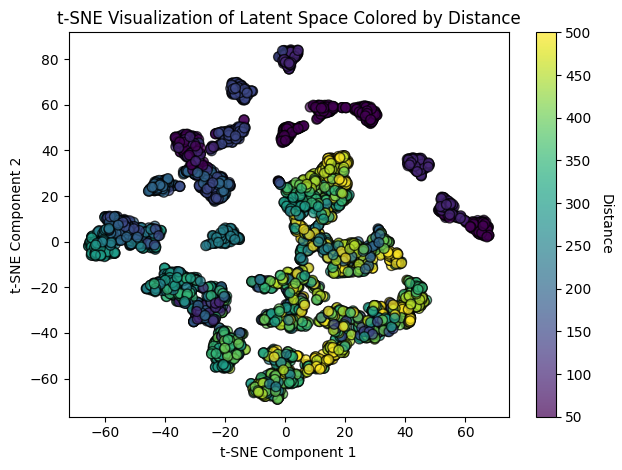

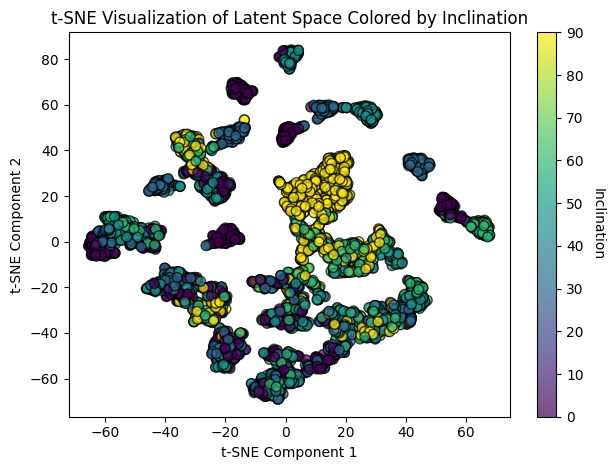

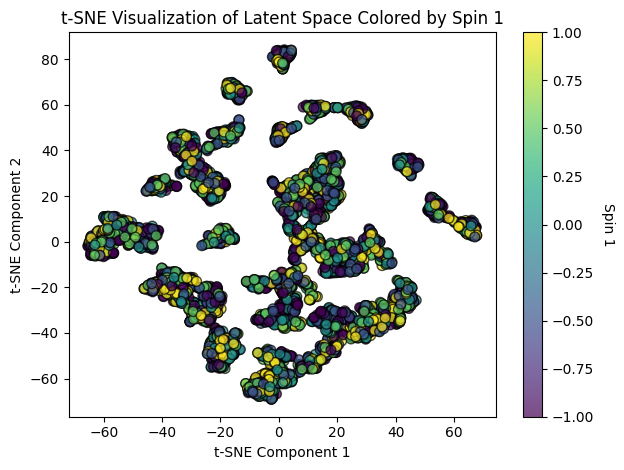

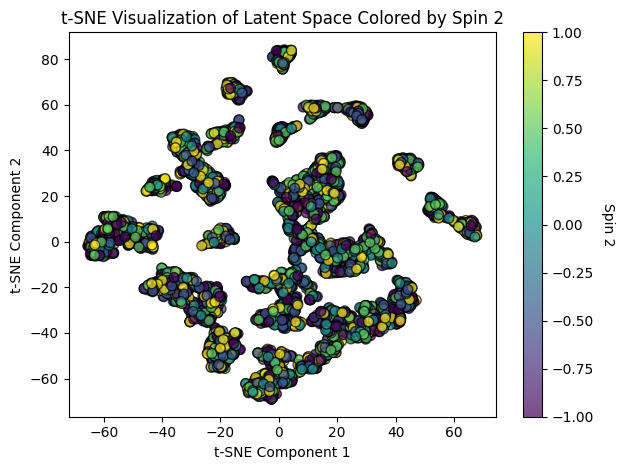

In [10]:
for i, param in enumerate(param_names):
    plt.figure()
    scatter = plt.scatter(
        df['x'], df['y'], 
        c=df[param], 
        cmap='viridis', 
        alpha=0.7,
        edgecolor='k',   # optional: adds black edge for better visibility
        s=50             # optional: marker size
    )
    
    cbar = plt.colorbar(scatter)
    cbar.set_label(param, rotation=270, labelpad=15)
    
    plt.title(f't-SNE Visualization of Latent Space Colored by {param}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.tight_layout()
    
    plt.savefig(f'{destination_folder}/{model.__class__.__name__}_tsne_{param.replace(" ", "_")}.png',
                bbox_inches='tight', dpi=300)
    plt.show()

    

In [11]:
# Create a combined plot using pairplot
print('Creating combined visualization...')
# Select a subset of the parameters for clarity
subset_df = df[['Mass 1', 'Mass 2', 'Distance', 'x', 'y']].copy()

Creating combined visualization...


/tmp/ipykernel_619154/2128569258.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


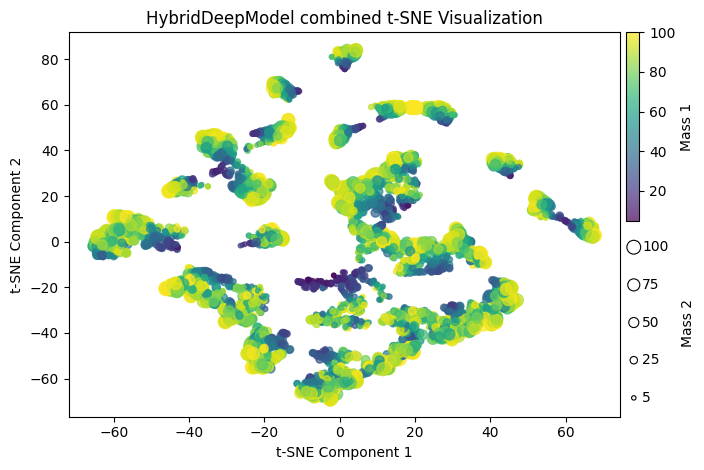

In [12]:
# Enhanced version with unfilled circles and better alignment
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


mass1 = subset_df['Mass 1'].values
mass2 = subset_df['Mass 2'].values
x = subset_df['x'].values
y = subset_df['y'].values

# Normalize for color
norm1 = plt.Normalize(mass1.min(), mass1.max())
cmap1 = plt.cm.viridis

# Scale sizes for visibility
sizes = np.interp(mass2, [mass2.min(), mass2.max()], [10, 99])

# Create figure
fig, ax = plt.subplots()

# Scatter plot
scatter = ax.scatter(x, y, c=mass1, s=sizes, cmap=cmap1, alpha=0.7)

# Add colorbar for Mass 1 (top right)
cax1 = inset_axes(ax, width="2.5%", height="49%", loc='upper right',
                  bbox_to_anchor=(.035, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cbar = fig.colorbar(scatter, cax=cax1)
cbar.set_label('Mass 1', labelpad=3)

# -----------------------------------------------------------------
cax_legend = inset_axes(ax, width="5%", height="49%", loc='lower right',
                        bbox_to_anchor=(.06, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)

cbar = fig.colorbar(scatter, cax=cax_legend)
cbar.set_label('Mass 2', labelpad=20, size=10)

cax_legend.set_frame_on(False)
cax_legend.set_xlim(0, 1)
cax_legend.set_ylim(0, 1)
cax_legend.set_xticks([])
cax_legend.set_yticks([])

# Define example Mass 2 values
example_masses = [5, 25, 50, 75, 100]
example_positions = np.linspace(0.1, 0.9, 5)
example_sizes = np.interp(example_masses, [mass2.min(), mass2.max()], [10, 99])

# Draw circles and labels in the *same* inset
for y_pos, s, m in zip(example_positions, example_sizes, example_masses):
    # Draw circle (e.g., at x=0.3)
    cax_legend.scatter([0.3], [y_pos], s=s, facecolors='none', edgecolors='black', linewidths=0.8)
    # Draw label (e.g., at x=0.6)
    cax_legend.text(0.6, y_pos, f"{m}", va='center', ha='left', fontsize=10, fontfamily='sans-serif')

# Titles and labels
ax.set_title(f'{model_class.__name__} combined t-SNE Visualization')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')

plt.tight_layout()
# plt.show()
plt.savefig(f'{destination_folder}/{model.__class__.__name__}_tsne_combined_enhanced.png', bbox_inches='tight', dpi=300)